In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("./tos.csv")

In [ ]:
df

In [5]:
df = df.drop("Unnamed: 0", axis=1)

In [6]:
df.head()

,data,score,class,filename
0,"signal does not sell, rent or monetize your pe...",25,good,signal.json
1,you must be at least 13 years old to use our s...,15,neutral,signal.json
2,you agree to resolve any claim you have with u...,0,neutral,signal.json
3,"we may modify, suspend, or terminate your acce...",60,bad,signal.json
4,we work with third parties to provide some of ...,15,bad,signal.json


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string

In [8]:
torch.manual_seed(420)
torch.cuda.is_available()
    

True

In [9]:
def prepare_tokens(text):
    if isinstance(text, str):
#         print(f"======={text}")
        text = text.split()
        table = str.maketrans('', '', string.punctuation)
        tokens = [w.translate(table) for w in text]
        
        return ' '.join(tokens)
    else:
        return None

In [10]:
df['tokens'] = df['data'].apply(prepare_tokens)

In [11]:
df.head()

,data,score,class,filename,tokens
0,"signal does not sell, rent or monetize your pe...",25,good,signal.json,signal does not sell rent or monetize your per...
1,you must be at least 13 years old to use our s...,15,neutral,signal.json,you must be at least 13 years old to use our s...
2,you agree to resolve any claim you have with u...,0,neutral,signal.json,you agree to resolve any claim you have with u...
3,"we may modify, suspend, or terminate your acce...",60,bad,signal.json,we may modify suspend or terminate your access...
4,we work with third parties to provide some of ...,15,bad,signal.json,we work with third parties to provide some of ...


In [12]:
%matplotlib inline
df['class_id'] = 0
df.loc[df["class"]=="neutral", "class_id"] = 1
df.loc[df["class"]=="good", "class_id"] = 2
df.loc[df["class"]=="blocker", "class_id"] = 3

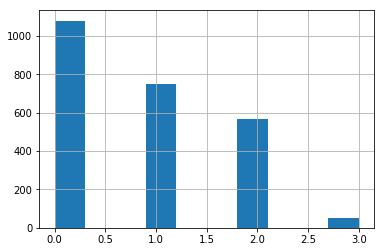

In [13]:
df.class_id.hist()

In [14]:
df = df.loc[df.class_id != 3]

In [15]:
df.shape

(2397, 6)

In [16]:
# tokenizer = get_tokenizer("basic_english")

word_to_ix = {'PAD': 0}
for sent in df.tokens.tolist():
    if sent:
#         print(sent)
        for word in sent.split():
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
# print(word_to_ix)
tag_to_ix = {"bad": 0, "neutral": 1, "good": 2, "blocker": 3}

In [ ]:
word_to_ix

In [18]:
len(word_to_ix)

6250

In [19]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 16

In [20]:
class TOSClaasifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size, batch_size):
        super(TOSClaasifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.target_size = target_size
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=0.3, num_layers=2)
        
        self.h1 = nn.Linear(hidden_dim*150, 512)
        self.hidden2tag = nn.Linear(512, target_size)
        self.batch_size = batch_size
        self.embed_dim = embedding_dim
        

    def forward(self, sentence):
#         print(sentence.shape)
        embeds = self.word_embeddings(sentence.view(self.batch_size,-1))
#         print(embeds.shape)
        lstm_out, _ = self.LSTM(embeds.view(self.batch_size, 150, self.embed_dim))
#         print(lstm_out.shape)
        lstm_out = lstm_out.contiguous().view(self.batch_size,-1)
#         print(lstm_out.shape)
        tag_space = self.h1(lstm_out)
#         print(tag_space.shape)

        tag_space = self.hidden2tag(tag_space)
#         print(tag_space.shape)
        
#         tag_score = F.log_softmax(tag_space.view(self.batch_size, -1, self.target_size))
        tag_score = F.log_softmax(tag_space, dim=0)
        tag_score = tag_score.view(self.batch_size, self.target_size)
#         print(tag_score)
#         tag_score = tag_score[:, -1] # get last batch of labels
        return tag_score
        

In [21]:
model = TOSClaasifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), 3, BATCH_SIZE)
model = model.cuda()


In [22]:
loss_fn = nn.NLLLoss().cuda()
# optimizer = optim.SGD(model.parameters(), lr=0.1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

# optimizer = optim.RMSprop(model.parameters())
optimizer = optim.Adam(model.parameters())

In [23]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq.split()]
    return torch.tensor(idxs, dtype=torch.long)

In [24]:
print(model)

TOSClaasifier(
  (word_embeddings): Embedding(6250, 128)
  (LSTM): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (h1): Linear(in_features=38400, out_features=512, bias=True)
  (hidden2tag): Linear(in_features=512, out_features=3, bias=True)
)


In [25]:
df = df.loc[~df.tokens.isna()]

In [26]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = np.zeros(seq_length-review_len).astype(np.int)
#             print(zeroes)
#             print(review.numpy())
            new = np.concatenate((review.numpy(),zeroes), axis=None)
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [27]:
seq_ids = df.tokens.apply(prepare_sequence, args=[word_to_ix]).tolist()
label_ids = df['class'].apply(prepare_sequence, args=[tag_to_ix]).tolist()

In [28]:
feats = pad_features(seq_ids, 150)

In [ ]:
label_ids

In [29]:
feats

array([[   1,    2,    3, ...,    0,    0,    0],
       [  17,   18,   19, ...,    0,    0,    0],
       [  17,   39,   25, ...,    0,    0,    0],
       ...,
       [  87,  185,    3, ...,    0,    0,    0],
       [ 122, 2832,   25, ...,    0,    0,    0],
       [  87,  158,   17, ...,    0,    0,    0]])

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

In [44]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=420)
for train, test in sss.split(feats, label_ids):
    train_X = feats[train]
    train_y = np.array(label_ids)[train]
    
    test_X = feats[test]
    test_y = np.array(label_ids)[test]

In [45]:
# train_X = feats[0:int(0.75*len(feats))]
# test_X = feats[int(0.75*len(feats)):]

# train_y = label_ids[0:int(0.75*len(label_ids))]
# test_y = label_ids[int(0.75*len(label_ids)):]

In [46]:
train_X[0]

array([  13,   82,   70, 2034,  284,   12,  135,   43,   29, 4993,  673,
          6, 4993, 4357,  120,  781,  558,  202,  276,   74,  195, 1349,
        195,  279,   82, 4993,   82,  548, 1143,   82, 1144, 2476,   70,
        129,  282,  280,  281,    6, 2715,  306,   13,  281,  282,   48,
       2106, 2107,   55,   58, 2108,   68, 2335,  767, 3746,   82, 2109,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [47]:
train_y[0]

0

In [48]:
def next_batch(X,y):
    i = 0
    n = len(X)
    
    while i <= n:
        yield X[i:i+BATCH_SIZE], y[i:i+BATCH_SIZE]
        i = i + BATCH_SIZE

In [49]:
for x, y in next_batch([0,1,2,3,4,5,6], [0,1,2,1,1,1,1]):
    print(x,y)

[0, 1, 2, 3, 4, 5, 6] [0, 1, 2, 1, 1, 1, 1]


In [50]:
# model = model.cuda()

for epoch in range(100):
    print(f"==================================={epoch}================================")
    train_loss = 0
    train_acc = 0
    train_idx = 0

    test_loss = 0
    test_acc = 0
    test_idx = 0

#     scheduler.step(epoch)
#     for sentence, label in list(zip(train_X, train_y)):
    for sentence, label in next_batch(train_X, train_y):
        if len(sentence) < BATCH_SIZE:
            continue
#         print(sentence, label)
        model.zero_grad()

        tag_scores = model(torch.LongTensor(sentence).view(BATCH_SIZE,150).cuda())
        loss = loss_fn(tag_scores, torch.LongTensor(label).cuda())
#         print(loss)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_acc += (tag_scores.argmax(1) == torch.LongTensor(label).cuda()).sum().item()
        train_idx += BATCH_SIZE
        
    print(train_loss / train_idx)
    print(train_acc / train_idx)
        
    
    for sentence, label in next_batch(test_X, test_y):
        if len(sentence) < BATCH_SIZE:
            continue
#         text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            tag_scores = model(torch.LongTensor(sentence).view(BATCH_SIZE,150).cuda())

            loss = loss_fn(tag_scores.view(BATCH_SIZE,-1), torch.LongTensor(label).cuda())
            test_loss += loss.item()
            
            test_acc += (tag_scores.argmax(1) == torch.LongTensor(label).cuda()).sum().item()
            test_idx += BATCH_SIZE

    print(test_loss / test_idx)
    print(test_acc/ test_idx)



===================================0================================
0.16781754261599138
0.5282451923076923
0.1641502742740241
0.5681818181818182
===================================1================================
0.1506988058009973
0.7373798076923077
0.16262866522778163
0.6150568181818182
===================================2================================
0.14356621240194029
0.8100961538461539
0.16540299186652357
0.5994318181818182
===================================3================================
0.1389083219692111
0.8762019230769231
0.16022068533030423
0.625
===================================4================================
0.1342470356478141
0.9146634615384616
0.16159544309431856
0.6349431818181818
===================================5================================
0.1316051329844273
0.9459134615384616
0.1608747819607908
0.6292613636363636
===================================6================================
0.12875487125263765
0.9573317307692307
0.16590956327590076
0.6150568

KeyboardInterrupt: 

In [54]:
import sklearn

sklearn.__version__

'0.19.1'

In [55]:
from sklearn.metrics import classification_report

In [ ]:
y_preds = []
y_true = []
for sentence, label in next_batch(test_X, test_y):
        if len(sentence) < BATCH_SIZE:
            continue
#         text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            tag_scores = model(torch.LongTensor(sentence).view(BATCH_SIZE,150).cuda())
            print("***********")
#             print(tag_scores.shape)
#             print(tag_scores.view(BATCH_SIZE,-1).shape)
            loss = loss_fn(tag_scores, torch.LongTensor(label).cuda())
            test_loss += loss.item()
            
#             print(tag_scores.shape)
            print(tag_scores.argmax(1))
            print(label)
            
            y_preds.append(tag_scores.argmax(1).cpu().numpy())
            y_true.append(label)
            test_acc += (tag_scores.argmax(1) == torch.LongTensor(label).cuda()).sum().item()
            test_idx += BATCH_SIZE
            
            print(test_acc/ test_idx)


In [69]:
y_true = np.array(y_true).flatten()

In [71]:
y_preds = np.array(y_preds).flatten()

In [72]:
print(classification_report(y_true, y_preds, target_names=["bad", "neutral", "good"]))

             precision    recall  f1-score   support

        bad       0.77      0.81      0.79       320
    neutral       0.73      0.76      0.74       217
       good       0.67      0.57      0.62       167

avg / total       0.73      0.74      0.73       704



In [82]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_true, y_preds)


Confusion matrix, without normalization
[[259  36  25]
 [ 31 164  22]
 [ 47  24  96]]


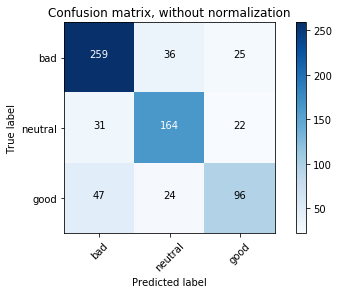

In [84]:
plot_confusion_matrix(cnf_matrix, classes=["bad", "neutral", "good"],
                      title='Confusion matrix, without normalization')
plt.show()